In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize

import statsmodels.formula.api as smf # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
ADS_DATAPATH = 'data/ads.csv'
CURRENCY_DATAPATH = 'data/currency.csv'

## Visualize data

In [3]:
ads = pd.read_csv(ADS_DATAPATH, index_col=['Time'], parse_dates=['Time'])
currency = pd.read_csv(CURRENCY_DATAPATH, index_col=['Time'], parse_dates=['Time'])

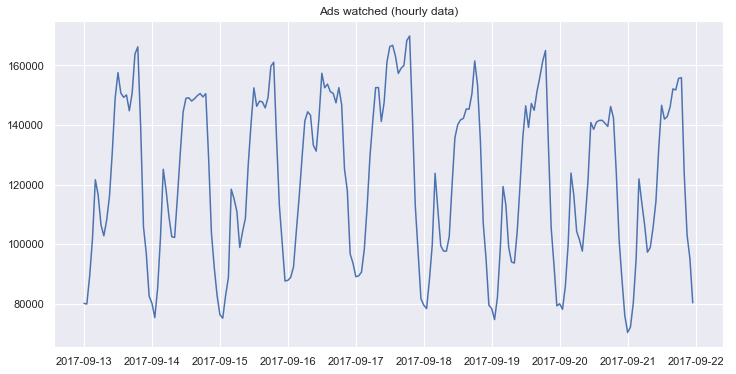

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(ads)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

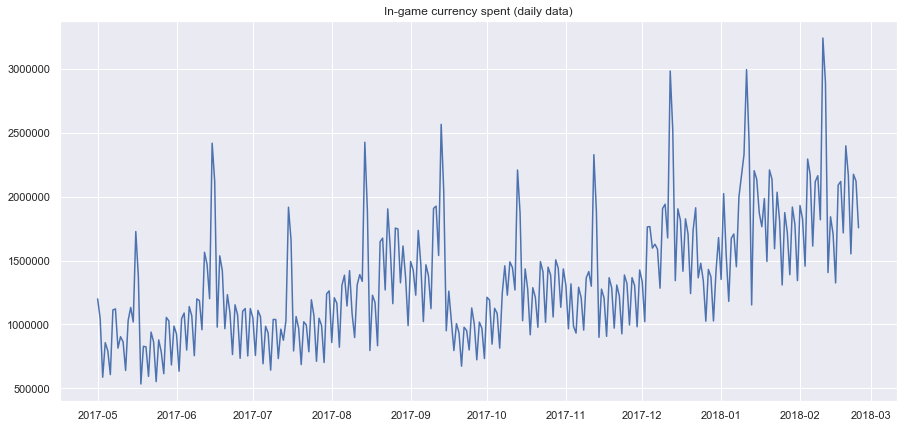

In [5]:
plt.figure(figsize=(15, 7))
plt.plot(currency)
plt.title('In-game currency spent (daily data)')
plt.grid(True)
plt.show()

## Import error metrics

In [6]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Moving average

Assume that the future value of the target depends on the average of its *k* previous values. 

This is called **moving average** .

In [7]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    
    return np.average(series[-n:])

#Prediction for the last observed day (past 24h)
moving_average(ads, 24)

116805.0

We cannot make predictions far in the future - in order to get the value for the next step, we need the previous values to be actually observed. However, moving average can *smooth* the original time series to identify trends. In the case of very noisy data, which is often encountered in finance, this procedure can hepl detect common patterns.

In [8]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    """
        series - dataframe with time series
        window - rolling window size
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies
    """
    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(15,5))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
        
        #Having confidence intervals for smoothed value
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series < lower_bound] = series[series < lower_bound]
            anomalies[series > upper_bound] = series[series > upper_bound]
            plt.plot(anomalies, 'ro', markersize=10)
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='upper left')
    plt.grid(True)

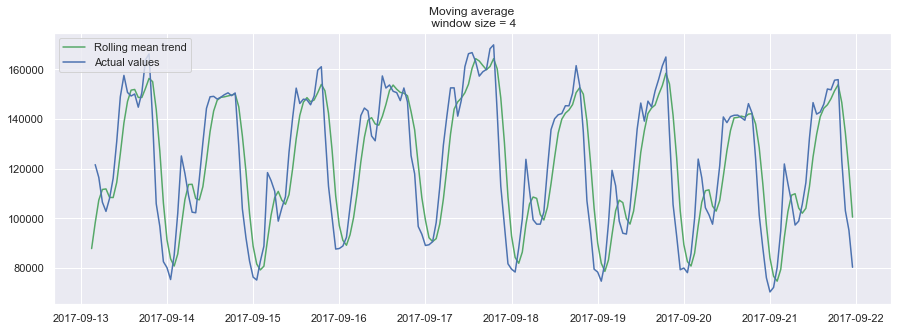

In [9]:
#Smooth by the previous 4 hours
plot_moving_average(ads, 4)

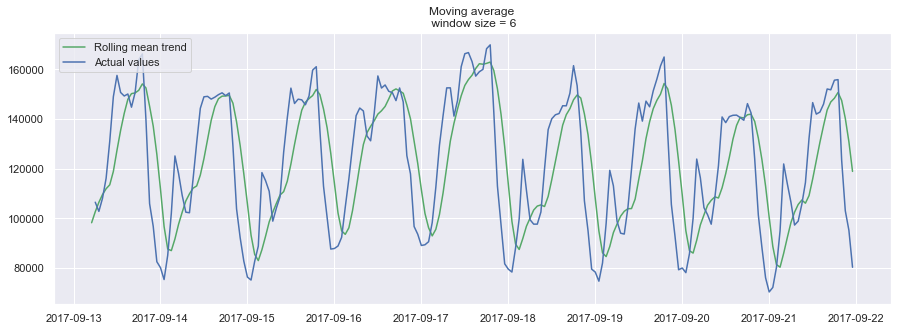

In [10]:
#Smooth by the previous 6 hours
plot_moving_average(ads, 6)

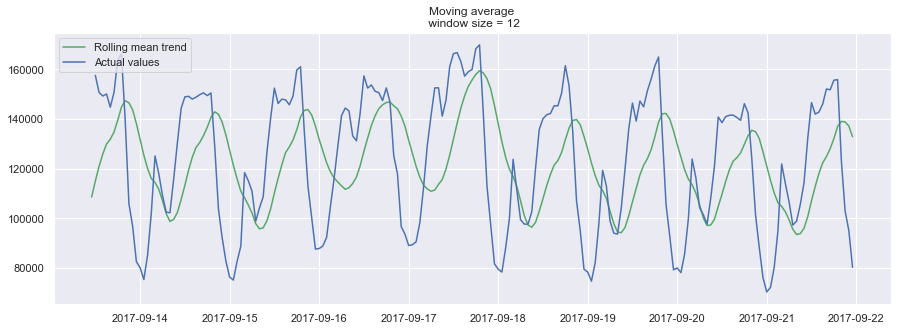

In [11]:
#Smooth by previous 12 hours
plot_moving_average(ads, 12)

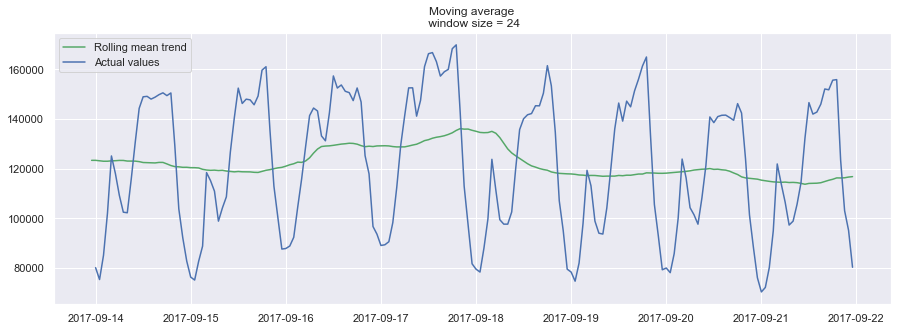

In [12]:
#Smooth by previous 24h (daily trend)
plot_moving_average(ads, 24)

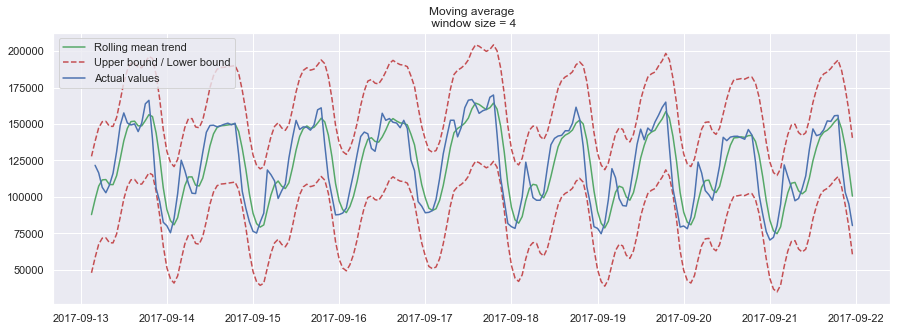

In [13]:
plot_moving_average(ads, 4, plot_intervals=True)

Create anomalies to check if the method can catch anomalies

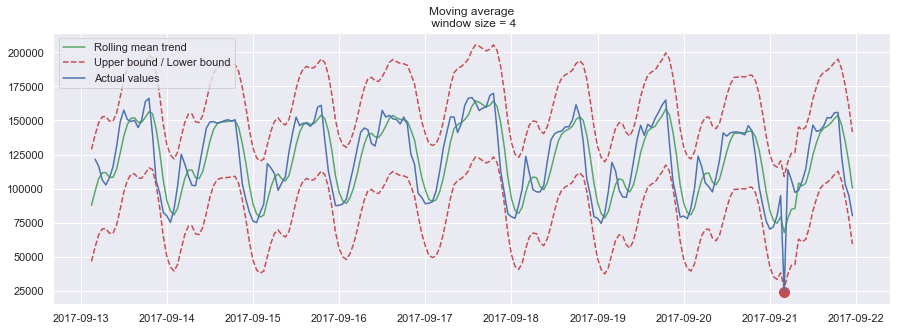

In [14]:
ads_anomaly = ads.copy()
ads_anomaly.iloc[-20] = ads_anomaly.iloc[-20] * 0.2

plot_moving_average(ads_anomaly, 4, plot_intervals=True, plot_anomalies=True)

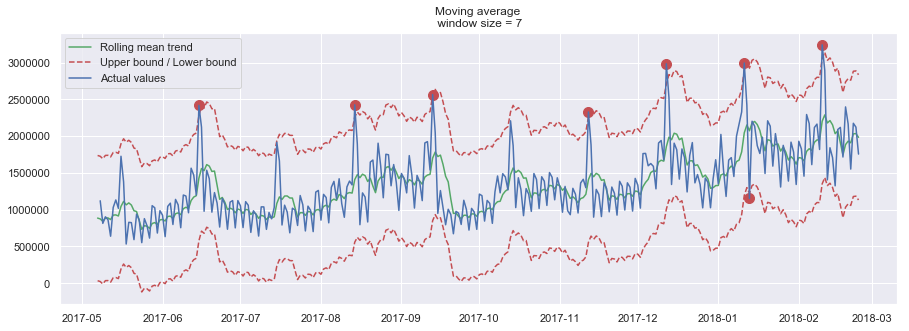

In [15]:
plot_moving_average(currency, 7, plot_intervals=True, plot_anomalies=True)# weekly smoothing

Above, the method is not robust enough, because it failed to find the monthly seasonality of the data and it identified all peaks as anomalies. Therefore, we need more complex models.

**Weighted average** is a simple modification to the moving average. The weights sum up to 1 with larger weights assigned to more recent observations.

In [16]:
def weighted_average(series, weights):
    """
        Calculate weighted average on series
    """
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n - 1] * weights[n]
    return float(result)

In [17]:
weighted_average(ads, [0.6, 0.3, 0.1])

98423.0

## Exponential smoothing

Exponential smoothing takes all *k* values, and assigns weights to them. However, the weights exponentially decrease as we move further back in time. 

A smoothing factor defines how quickly we "forget" the last available true observation. The smaller it is, the more influence the previous observations have, and the smoother the series is.

In [18]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [19]:
def plot_exponential_smoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

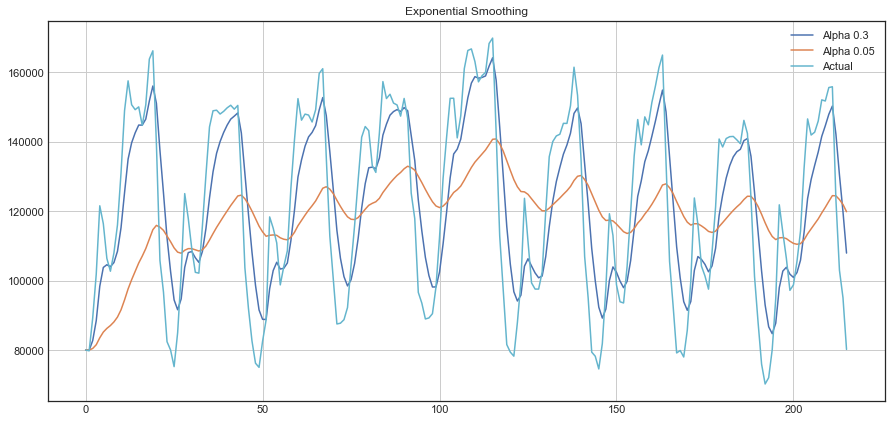

In [20]:
plot_exponential_smoothing(ads.Ads, [0.3, 0.05])

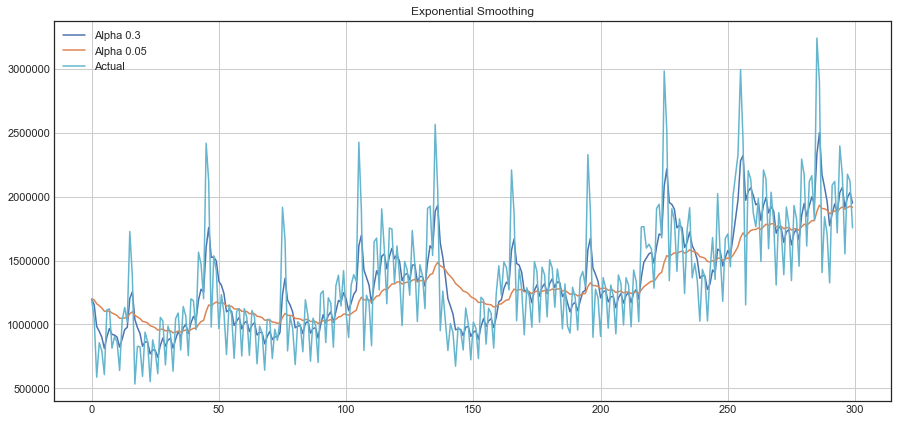

In [21]:
plot_exponential_smoothing(currency.GEMS_GEMS_SPENT, [0.3, 0.05])

## Double exponential smoothing

Now, we apply the same exponential smoothing to the trend by assuming that the future direction of the time series changes depending on the previous weighted changes.

In [22]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

In [23]:
def plot_double_exponential_smoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

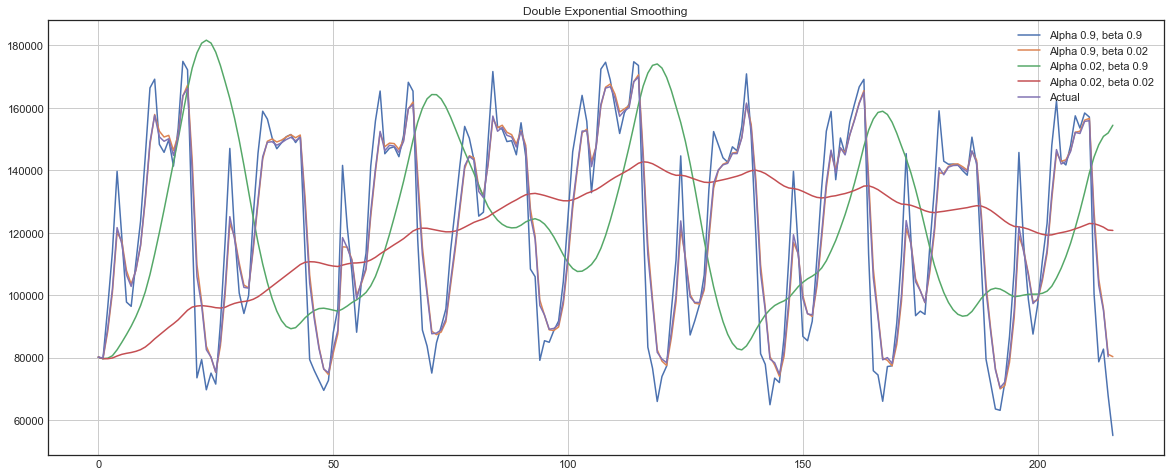

In [24]:
plot_double_exponential_smoothing(ads.Ads, alphas=[0.9, 0.02], betas=[0.9, 0.02])

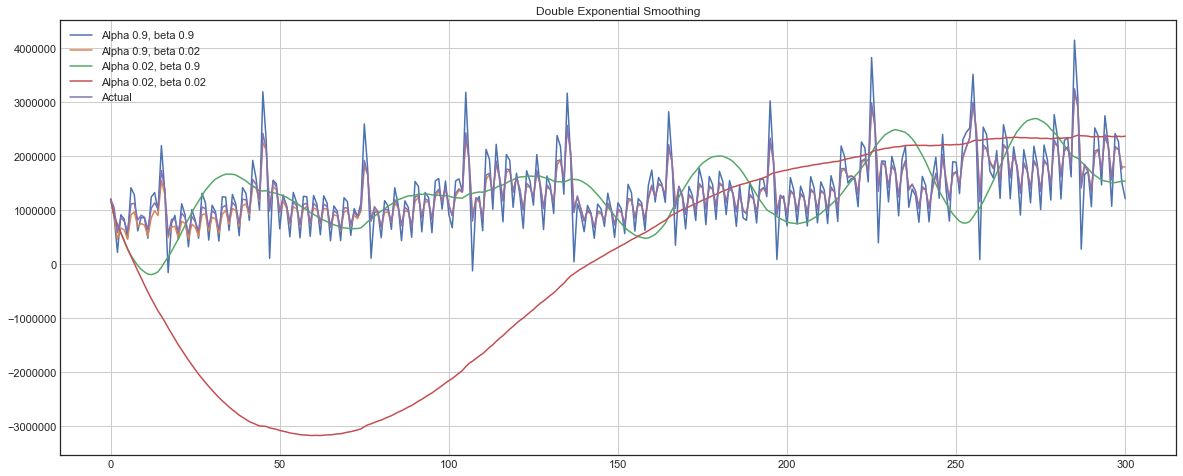

In [25]:
plot_double_exponential_smoothing(currency.GEMS_GEMS_SPENT, alphas=[0.9, 0.02], betas=[0.9, 0.02])

## Triple exponential smoothing - Holt-Winters

Now, we add a third component: seasonality

In [26]:
class HoltWinters:
    """
        Holt-Winters model with anomalies detection using Brutlag method
        
        series - initial time series
        slen - length of a season
        alpha, beta, gamma - Holt-Winters model coefficients
        n_preds - prediction horizon
        scaling_factor - sets the width of the confidence interval by Brutlag (usually between 2 and 3)
    """
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
    def initial_trend(self):
        summation = 0.0
        for i in range(self.slen):
            summation += float(self.series[i + self.slen] - self.series[i]) / self.slen
        return summation / self.slen
    
    def initial_season_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series) / self.slen)
        
        #Calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen * j : self.slen * j + self.slen]) / float(self.slen))
        
        #Calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen * j + i] - season_averages[j]
            seasonals[i] = sum_of_vals_over_avg / n_seasons
        return seasonals
    
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBound = []
        self.LowerBound = []
        
        seasonals = self.initial_season_components()
        
        for i in range(len(self.series) + self.n_preds):
            #Components initialization
            if i == 0:
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i % self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBound.append(self.result[0] +
                                       self.scaling_factor *
                                       self.PredictedDeviation[0])
                
                self.LowerBound.append(self.result[0] - 
                                       self.scaling_factor *
                                       self.PredictedDeviation[0])
                
                continue
                
            #Predict
            if i >= len(self.series):
                m = i - len(self.series) + 1
                self.result.append((smooth + m * trend) + seasonals[i % self.slen])
                
                #When predicting, we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1] * 1.01)
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha * (val - seasonals[i % self.slen]) + (1 - self.alpha) * (smooth + trend)
                trend = self.beta * (smooth - last_smooth) + (1 - self.beta) * trend
                seasonals[i % self.slen] = self.gamma * (val - smooth) + (1 - self.gamma) * seasonals[i % self.slen]
                self.result.append(smooth + trend + seasonals[i % self.slen])
                
                #Deviation calculated according to Brutlag algorithm
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) + (1 - self.gamma) * self.PredictedDeviation[-1])
                
            self.UpperBound.append(self.result[-1] +
                                   self.scaling_factor *
                                   self.PredictedDeviation[-1])
            
            self.LowerBound.append(self.result[-1] - 
                                   self.scaling_factor *
                                   self.PredictedDeviation[-1])
            
            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

## Cross-validation in time series

Use cross-validation to the `ads` dataset to find the best parameters to Holt-Winters. Because there is daily seasonality, `slen = 24`.

In [27]:
from sklearn.model_selection import TimeSeriesSplit

def time_series_CV_score(params, 
                         series, 
                         loss_function=mean_squared_error, 
                         slen=24):
    """
        Return error of cross-validation
        
        params - vector of parameters for optimization
        series - dataset with time series
        slen - season length for Holt-Winters
    """
    
    #Initialize error array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    #set the number of folds for cross validation
    tscv = TimeSeriesSplit(n_splits = 3)
    
    #Iterate over folds, train model, forecast and calculate error
    for train, test in tscv.split(values):
        
        model = HoltWinters(series = values[train], 
                            slen = slen,
                            alpha = alpha,
                            beta = beta,
                            gamma = gamma,
                            n_preds = len(test))
        
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

Smoothing parameters must be between 0 and 1. Therefore, to minimize the loss function, we use Truncated Newton conjugate gradient.

In [28]:
data = ads.Ads[:-20]

#Initialize smoothing parameters
x = [0, 0, 0]

#Minimize the loss function
opt = minimize(time_series_CV_score, 
               x0 = x, 
               args = (data, mean_squared_log_error),
               method = 'TNC', 
               bounds = ((0, 1), (0, 1), (0, 1)))

#Take optimal values
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

#Train model with optimal values
model = HoltWinters(data, 
                    slen = 24,
                    alpha = alpha_final,
                    beta = beta_final, 
                    gamma = gamma_final,
                    n_preds = 50, 
                    scaling_factor = 3)

model.triple_exponential_smoothing()

0.11652680227350454 0.002677697431105852 0.05820973606789237


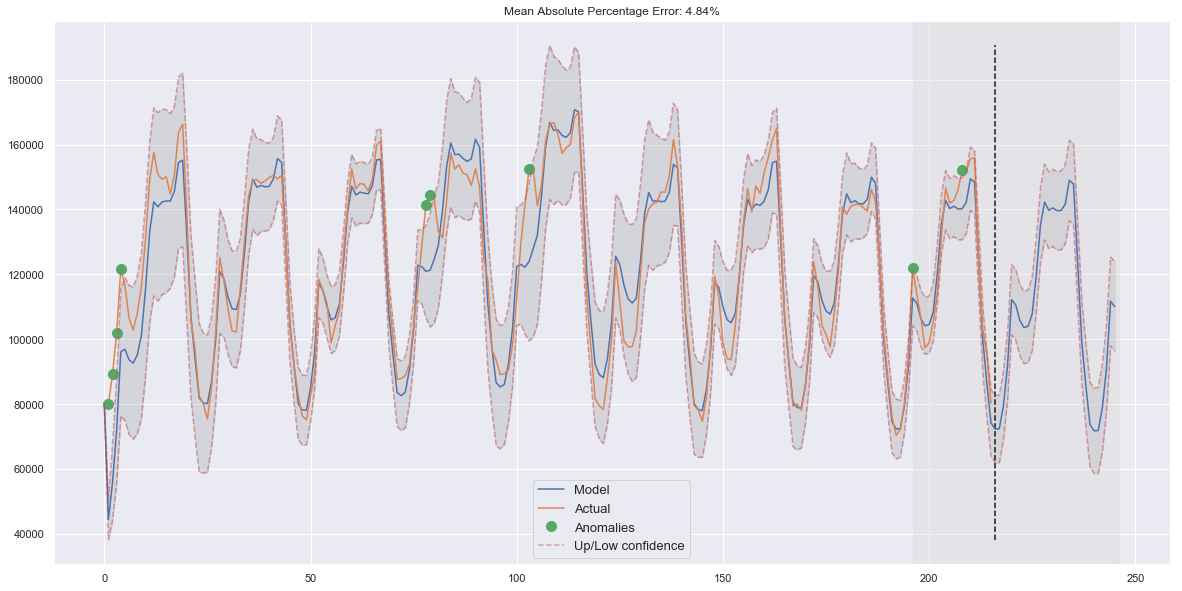

In [29]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBound[:len(series)]] = \
            series.values[series.values<model.LowerBound[:len(series)]]
        anomalies[series.values>model.UpperBound[:len(series)]] = \
            series.values[series.values>model.UpperBound[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBound, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBound, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBound, 
                         y2=model.LowerBound, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBound), ymax=max(model.UpperBound), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);
    
plotHoltWinters(ads.Ads, plot_intervals=True, plot_anomalies=True)

Text(0.5, 1.0, "Brutlag's predicted deviation")

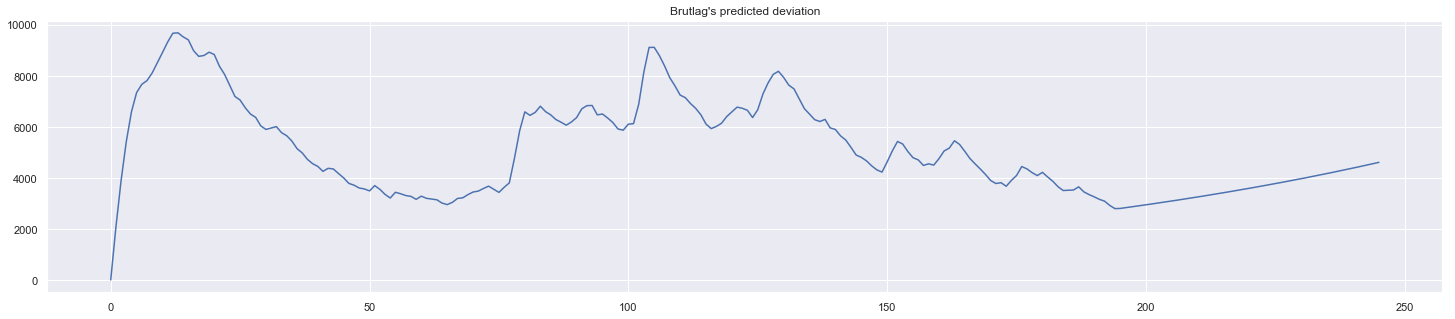

In [30]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation")

Doing the same, for the other dataset

In [31]:
data = currency.GEMS_GEMS_SPENT[:-50]
slen = 30 #30-day seasonality

x = [0, 0, 0]

opt = minimize(time_series_CV_score, 
               x0 = x,
               args = (data, mean_absolute_percentage_error, slen),
               method = 'TNC', 
               bounds = ((0, 1), (0, 1), (0, 1)))

alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

model = HoltWinters(data, 
                    slen = slen,
                    alpha = alpha_final,
                    beta = beta_final,
                    gamma = gamma_final,
                    n_preds = 100,
                    scaling_factor = 3)

model.triple_exponential_smoothing()

0.012841445048055122 0.04883371471892228 0.00943678056045777


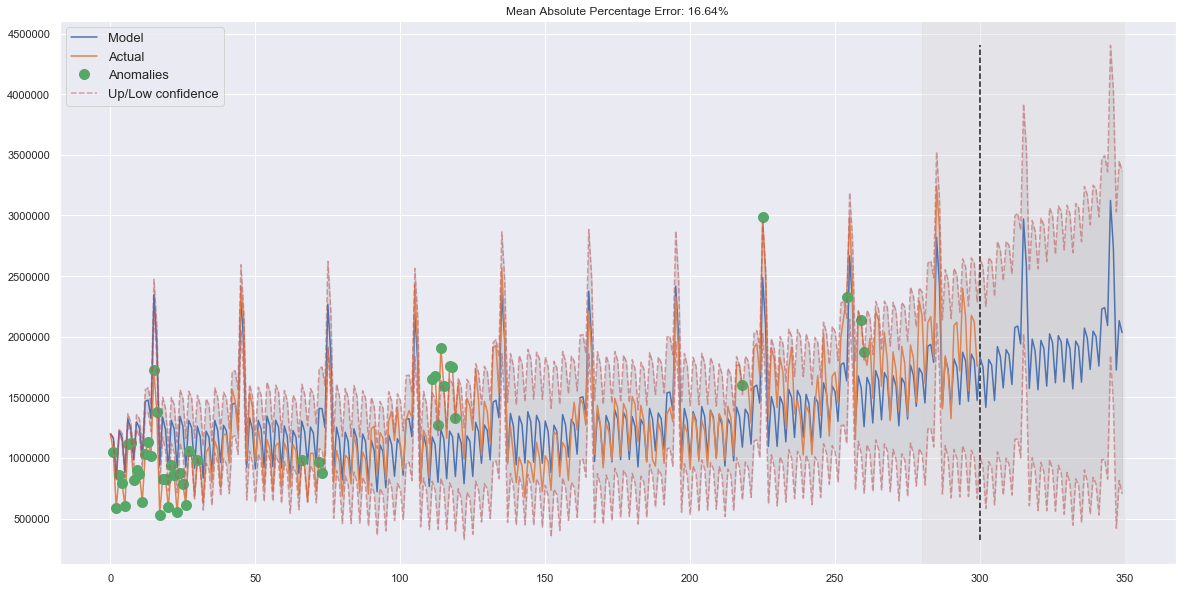

In [32]:
plotHoltWinters(currency.GEMS_GEMS_SPENT, plot_intervals=True, plot_anomalies=True)

Text(0.5, 1.0, "Brutlag's predicted deviation")

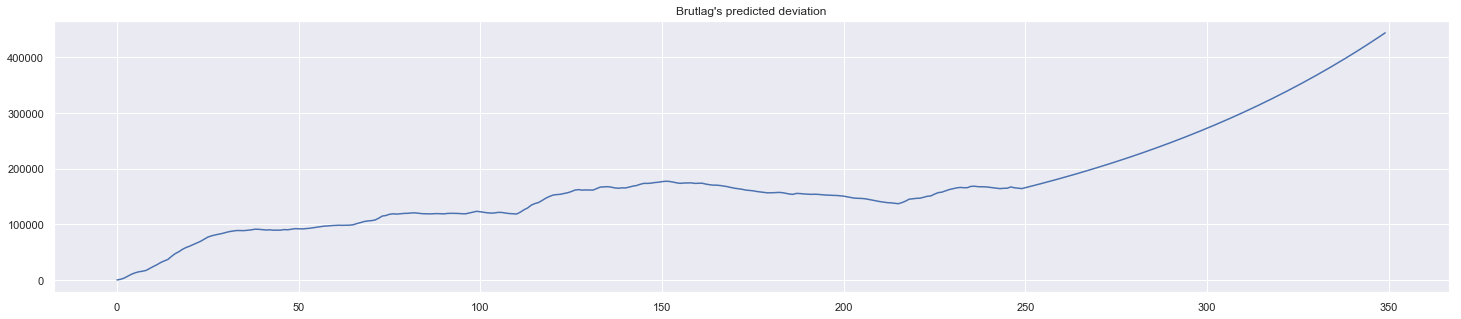

In [33]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation")

## Stationarity 

Stationarity: statistical properties do not change over time (constant mean and variance over time), and covariance is time indepedendant.

To detect stationarity, we lok at the white noise and random walks.

### White noise 

#### Example of stationarity 

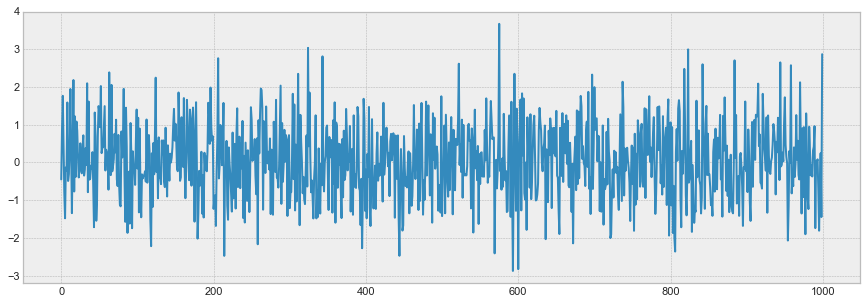

In [34]:
white_noise = np.random.normal(size=1000)

with plt.style.context('bmh'):
    plt.figure(figsize=(15,5))
    plt.plot(white_noise)

#### Example of non-stationarity 

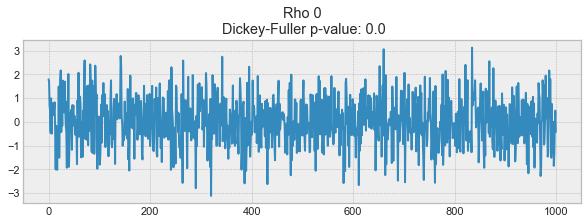

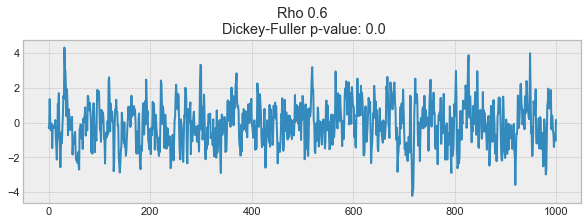

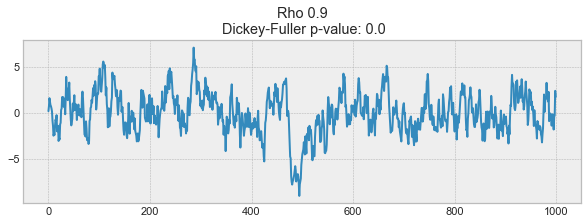

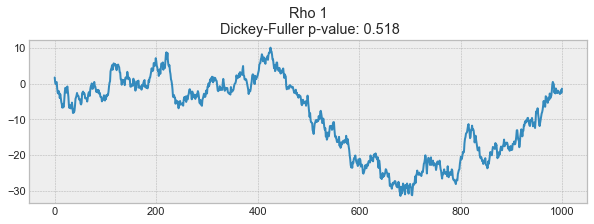

In [35]:
def plot_process(rho, n_samples=1000):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]
        
    with plt.style.context('bmh'):
        plt.figure(figsize=(10,3))
        plt.plot(x)
        plt.title('Rho {}\n Dickey-Fuller p-value: {}'.format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))
        
for rho in [0, 0.6, 0.9, 1]:
    plot_process(rho = rho)

## Getting rid of non-stationarity and building SARIMA 

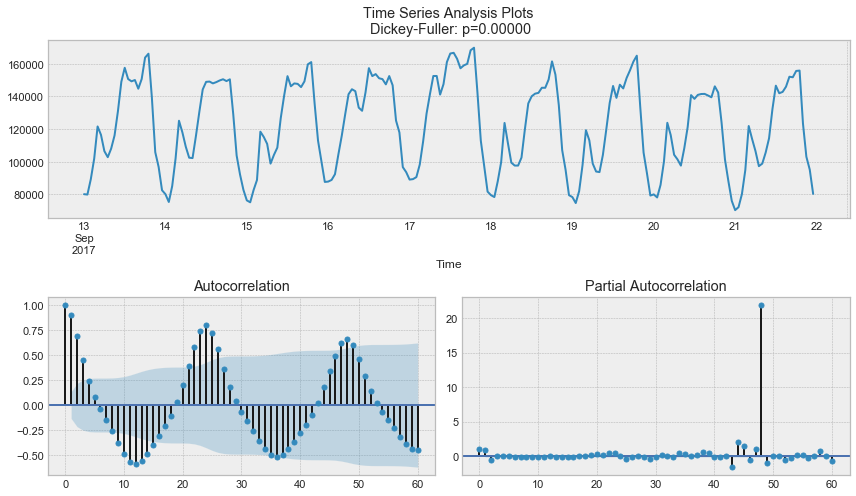

In [36]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey-Fuller test
        
        y - time seris
        lags - how many lags to include in ACF, PACF, calculation
    """
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(ads.Ads, lags=60)

By the Dickey-Fuller test, the time series is stationary, since p = 0 . Therefore, the null hypothesis is rejected.

**Removes seasonality**

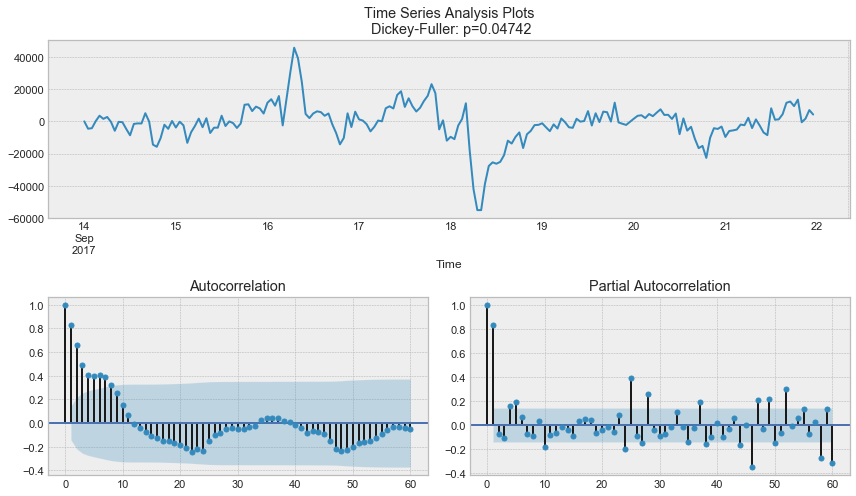

In [37]:
ads_diff = ads.Ads - ads.Ads.shift(24)
tsplot(ads_diff[24:], lags=60)

Reduce autocorrelation has too many significant lags. Take first difference

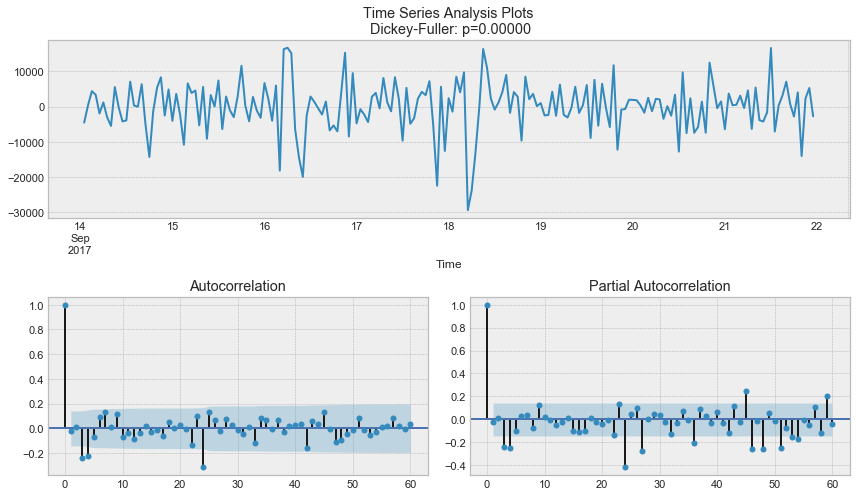

In [38]:
ads_diff = ads.Ads - ads.Ads.shift(24)
ads_diff = ads_diff - ads_diff.shift(1)
tsplot(ads_diff[24 + 1:], lags=60)

We can start modelling, because the the autocorrelation decreased, there are less peaks in the partial autocorrelation plot and the Dickey-Fuller test shows that the series is stationary.

## ARIMA-family crash course

**SARIMA(p, d, q)(P, D, Q, s) - Seasonal Autoregression Moving Average model**

**AR(p)** - Autoregression model, the regression of the time series onto itself. Assume that current series values depend on its previous values with some lag. The maximum lag in the model is reffered as **p**. To determine **p**, we need to have a look at the PACF plot and find the biggest significant lag after which most other lags are not significant.

**MA(q)** - moving average model. Assume the current error depends on the previous one with some lag, which is referred to as **q**. Initial value can be found on the ACF plot with similar logic as to **AR**.

**AR(p) + MA(q) = ARMA(p,q)**

If the model is stationary, this is sufficient.

**I(d)** - order of integration. It is the number of nonseasonal differences needed for making the series stationary.

Therefore, we get an **ARIMA(p, d, q)** model which can now handle non-stationary data.

**S(s)** - season period length of the series

This brings 3 additional parameters:

**P** - order of autoregression for seasonal component of the model, which can be derived from PACF. However, this time, we look at the number of significant lags, which are multiples of the seasonal period length. 

---

For example, if the period is 24 and the 24th and 48th lags are significant, then **P** is 2.

**Q** - moving average model of the seasonal component. Same logic as **P** but using ACF plot.

**D**  - order of seasonal integration. Can be equal to 1 or 0, depending on whether seasonal differences were applied or not

In our case:

* **p** is probably 4, since it's the last significant lag on PACF after which most others are less significant

* **d** is 1, because we took the first difference

* **q** is around 4 as seen on ACF

* **P** might be 2, since 24th and 48th lags are significant on PACF

* **D** is 1 because we performed seasonal differentiation

* **Q** is 1, because the 24th lag is significant, and not the 48th

Now, we test various models tofind the best one:

In [39]:
#Set initial values and some bounds
ps = range(2, 5)
d = 1
qs = range(2, 5)
Ps = range(0, 3)
D = 1
Qs = range(0, 2)
s = 24

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

54

In [40]:
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(ads.Ads, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

In [41]:
#Set parameters that give the lowest AIC (Akaike Information Criteria)

p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(ads.Ads, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                Ads   No. Observations:                  216
Model:             SARIMAX(2, 1, 3)x(1, 1, 1, 24)   Log Likelihood               -1936.321
Date:                            Mon, 28 Jan 2019   AIC                           3888.642
Time:                                    16:13:30   BIC                           3914.660
Sample:                                09-13-2017   HQIC                          3899.181
                                     - 09-21-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7913      0.270      2.928      0.003       0.262       1.321
ar.L2         -0.5503      0.306   

Make predictions

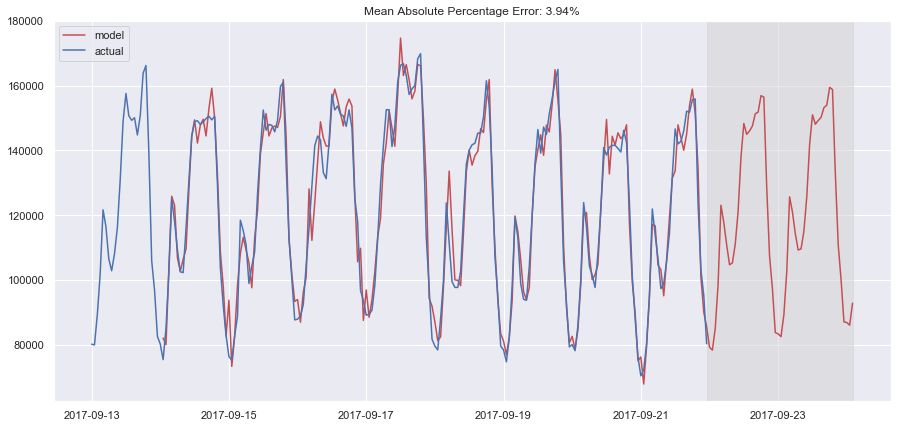

In [42]:
def plot_SARIMA(series, model, n_steps):
    """
        Plot model vs predicted values
        
        series - dataset with time series
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
    """
    
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    #Make a shift on s+d steps, because these values were unobserved by the model due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    #Forecast on n_steps forward
    forecast = model.predict(start=data.shape[0], end=data.shape[0] + n_steps)
    forecast = data.arima_model.append(forecast)
    #Calculate error
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    
    plt.figure(figsize=(15, 7))
    plt.title('Mean Absolute Percentage Error: {0:.2f}%'.format(error))
    plt.plot(forecast, color='r', label='model')
    plt.axvspan(data.index[-1], forecast.index[-1],alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label='actual')
    plt.legend()
    plt.grid(True);
    
plot_SARIMA(ads, best_model, 50)

## Lags of time series

Shifting the series **n** steps back, we get a feature column where the current values of the time series is aligned with its value at the time `t-n`. If we make a 1 la shift and train a model on that feature, the model will be able to forecast 1 step ahead, having observed the current state of the series. Increasing the lag will allow the model to predict more steps ahead, but it will use data observed more steps back. This might introduce more errors. Therefore, we need to find balance betwee optimal prediciton quality and length of forecasting horizon.

In [43]:
# Creating a copy of the initial datagrame to make various transformations 
data = pd.DataFrame(ads.Ads.copy())
data.columns = ["y"]

# Adding the lag of the target variable from 6 steps back up to 24
for i in range(6, 25):
    data["lag_{}".format(i)] = data.y.shift(i)

Let's train a simple model

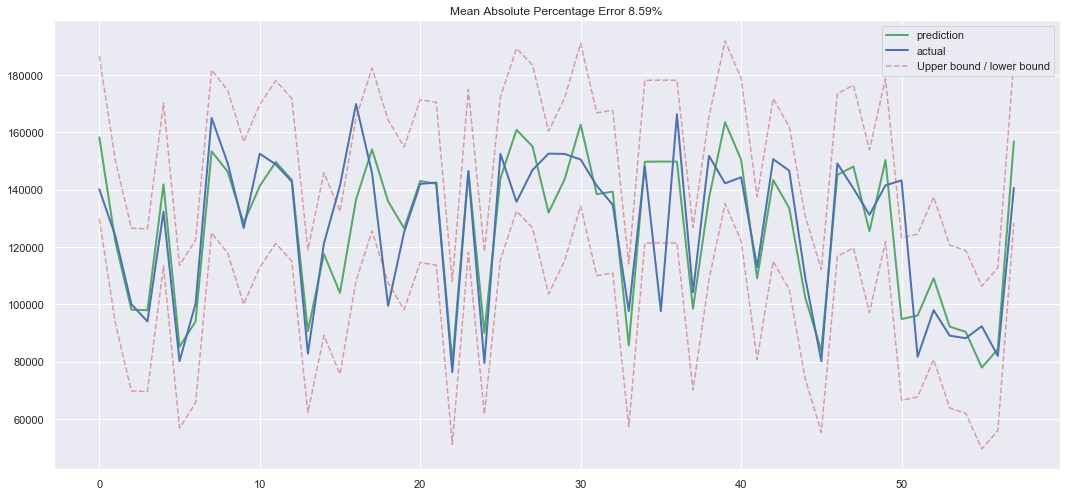

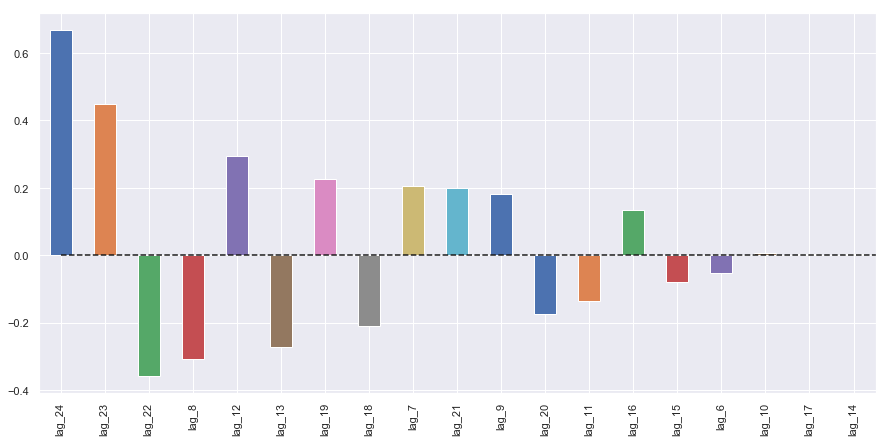

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split

tscv = TimeSeriesSplit(n_splits=5)

def plot_model_results(model, X_train, X_test, plot_intervals=False, plot_anomalies=False, scale=1.96):
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15,7))
    plt.plot(prediction, 'g', label='prediction', linewidth=2)
    plt.plot(y_test.values, label='actual', linewidth=2)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train,
                             cv=tscv,
                             scoring='neg_mean_squared_error')
        deviation = np.sqrt(cv.std())
        lower = prediction - (scale * deviation)
        upper = prediction + (scale * deviation)
        
        plt.plot(lower, 'r--', label='Upper bound / lower bound', alpha=0.5)
        plt.plot(upper, 'r--', alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN] * len(y_test))
            anomalies[y_test < lower] = y_test[y_test < lower]
            anomalies[y_test > upper] = y_test[y_test > upper]
            plt.plot(anomalies, 'o', markersize=10, label='Anomalies')
            
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title('Mean Absolute Percentage Error {0:.2f}%'.format(error))
    plt.legend(loc='best')
    plt.tight_layout()
    plt.grid(True)
    
def plot_coefficients(model):
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');
    
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

lr = LinearRegression()
lr.fit(X_train, y_train)

plot_model_results(lr, X_train, X_test, plot_intervals=True)
plot_coefficients(lr)

Add hour, day of the week and boolean for weekend

In [45]:
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1

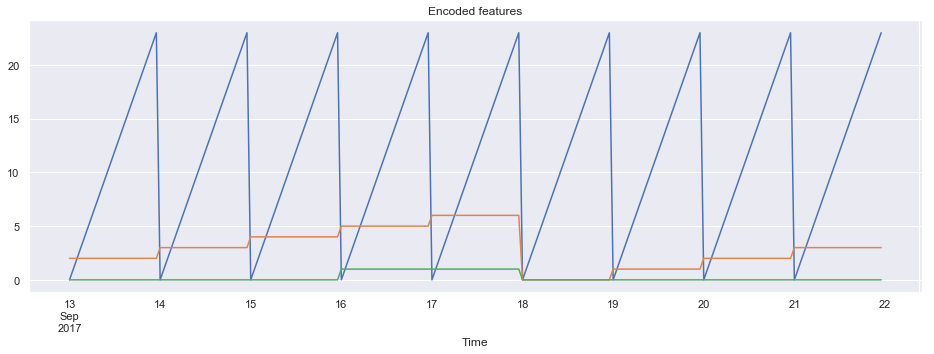

In [46]:
plt.figure(figsize=(16,5))
plt.title('Encoded features')
data.hour.plot()
data.weekday.plot()
data.is_weekend.plot()
plt.grid(True)

Regularize data

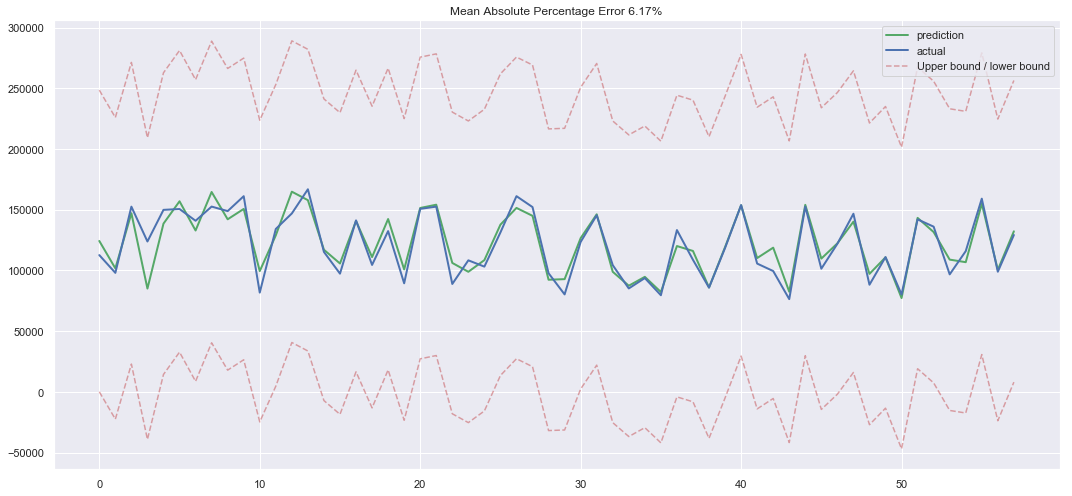

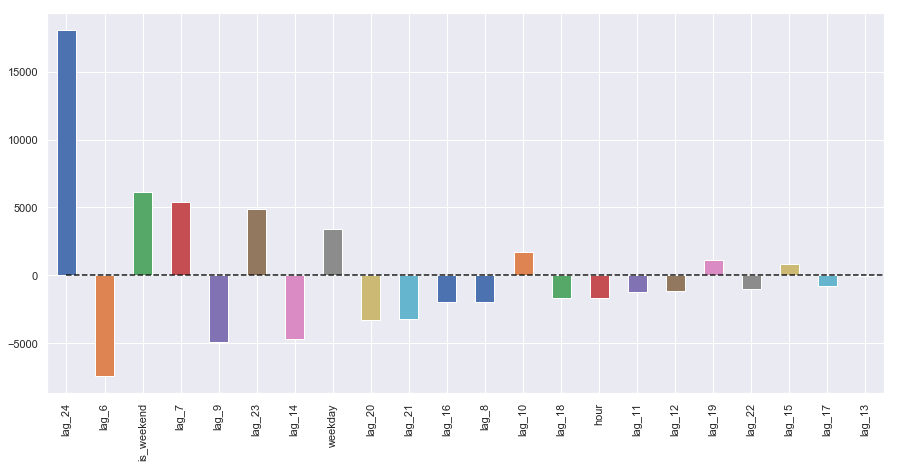

In [47]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plot_model_results(lr, X_train_scaled, X_test_scaled, plot_intervals=True)
plot_coefficients(lr)

Error went slightly down. `is_weekend` is a rather important feature

## Regularization and feature selection 

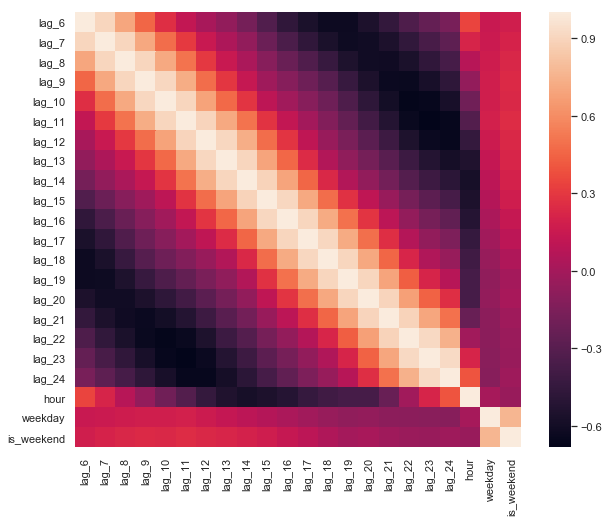

In [48]:
plt.figure(figsize=(10,8))
sns.heatmap(X_train.corr())

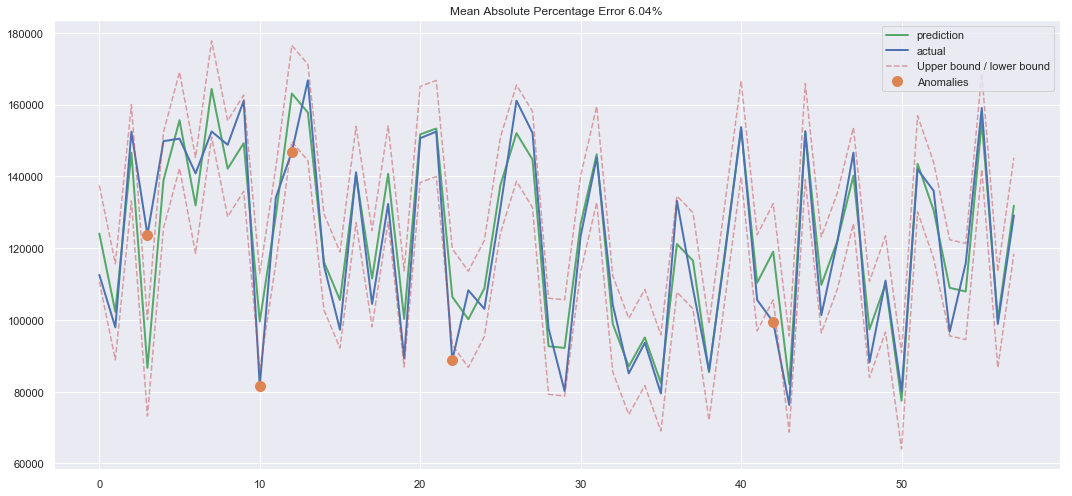

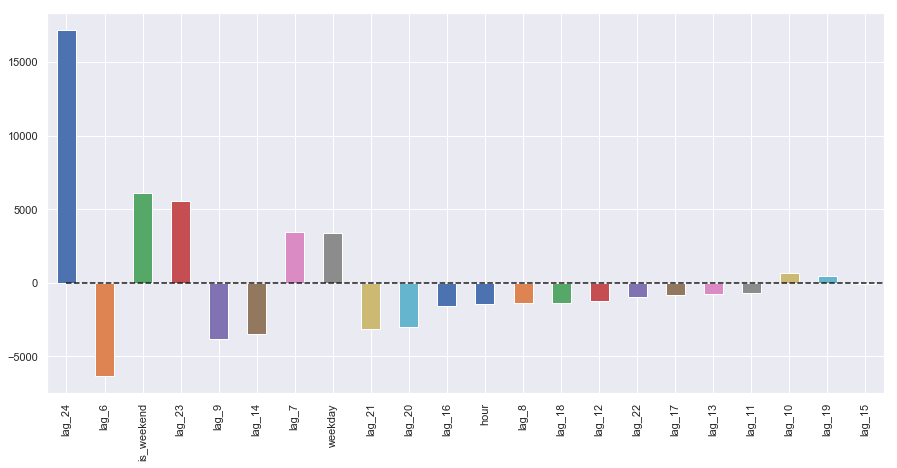

In [49]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv = tscv)
ridge.fit(X_train_scaled, y_train)

plot_model_results(ridge, X_train_scaled, X_test_scaled, plot_intervals=True, plot_anomalies=True)

plot_coefficients(ridge)

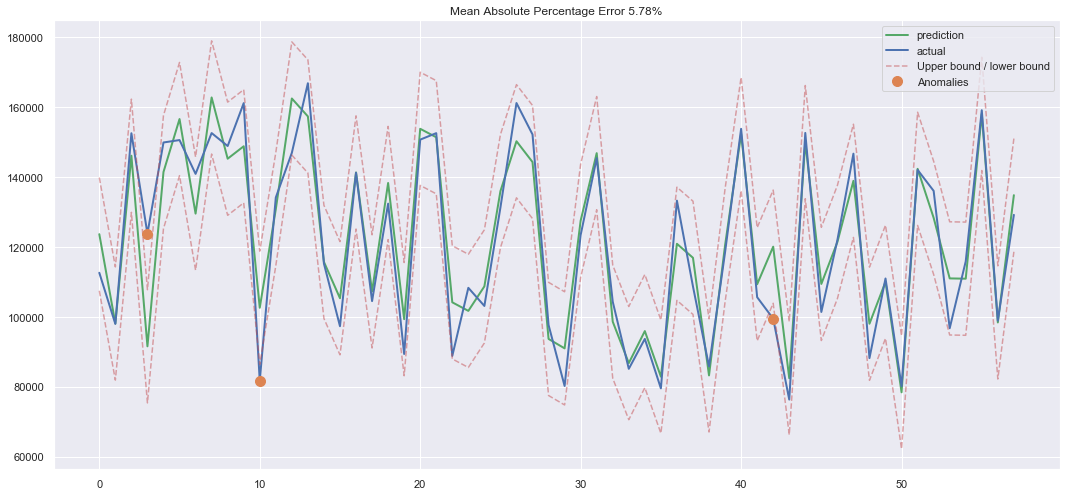

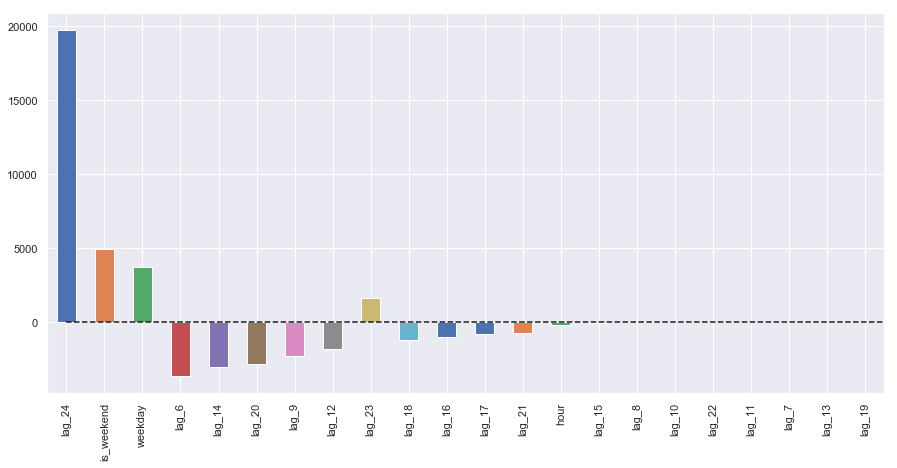

In [50]:
lasso = LassoCV(cv = tscv)
lasso.fit(X_train_scaled, y_train)

plot_model_results(lasso, X_train_scaled, X_test_scaled, plot_intervals=True, plot_anomalies=True)

plot_coefficients(lasso)

## Boosting 

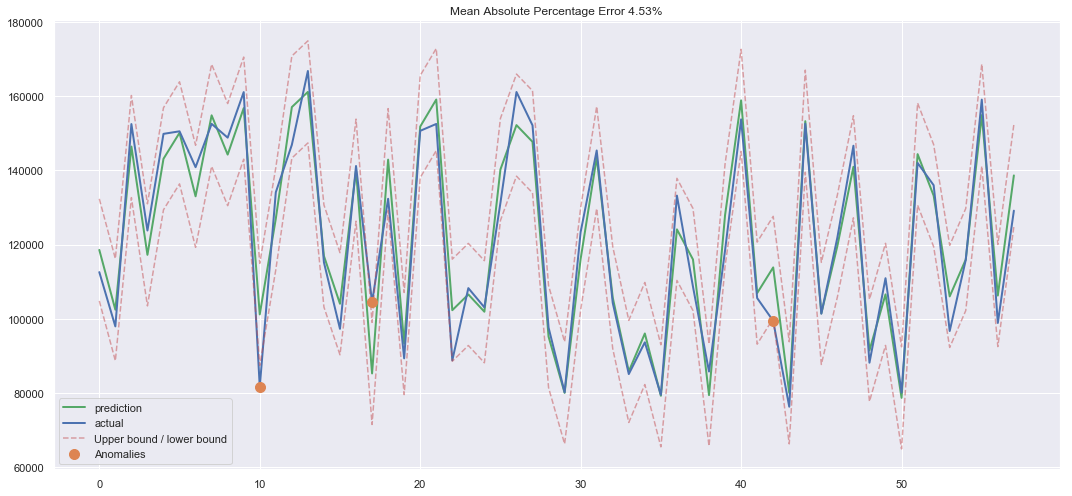

In [52]:
from xgboost import XGBRegressor

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

plot_model_results(xgb, X_train_scaled, X_test_scaled, plot_intervals=True, plot_anomalies=True)